In [7]:
#=========================================
# All credit for this starter notebook to 213tubo
# https://www.kaggle.com/code/tubotubo/starter-notebook-multi-target-prediction
#-----------------------------------------

import warnings
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import optuna
import polars as pl
import polars.selectors as cs
from catboost import CatBoostRegressor, MultiTargetCustomMetric
from numpy.typing import ArrayLike, NDArray
from polars.testing import assert_frame_equal
from sklearn.base import BaseEstimator
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore", message="Failed to optimize method")


#DATA_DIR = Path("/kaggle/input/child-mind-institute-problematic-internet-use")
DATA_DIR = Path("./data")

TARGET_COLS = [
    "PCIAT-PCIAT_01",
    "PCIAT-PCIAT_02",
    "PCIAT-PCIAT_03",
    "PCIAT-PCIAT_04",
    "PCIAT-PCIAT_05",
    "PCIAT-PCIAT_06",
    "PCIAT-PCIAT_07",
    "PCIAT-PCIAT_08",
    "PCIAT-PCIAT_09",
    "PCIAT-PCIAT_10",
    "PCIAT-PCIAT_11",
    "PCIAT-PCIAT_12",
    "PCIAT-PCIAT_13",
    "PCIAT-PCIAT_14",
    "PCIAT-PCIAT_15",
    "PCIAT-PCIAT_16",
    "PCIAT-PCIAT_17",
    "PCIAT-PCIAT_18",
    "PCIAT-PCIAT_19",
    "PCIAT-PCIAT_20",
    "PCIAT-PCIAT_Total",
    "sii",
]

FEATURE_COLS = [
    "Basic_Demos-Enroll_Season",
    "Basic_Demos-Age",
    "Basic_Demos-Sex",
    "CGAS-Season",
    "CGAS-CGAS_Score",
    "Physical-Season",
    "Physical-BMI",
    "Physical-Height",
    "Physical-Weight",
    "Physical-Waist_Circumference",
    "Physical-Diastolic_BP",
    "Physical-HeartRate",
    "Physical-Systolic_BP",
    "Fitness_Endurance-Season",
    "Fitness_Endurance-Max_Stage",
    "Fitness_Endurance-Time_Mins",
    "Fitness_Endurance-Time_Sec",
    "FGC-Season",
    "FGC-FGC_CU",
    "FGC-FGC_CU_Zone",
    "FGC-FGC_GSND",
    "FGC-FGC_GSND_Zone",
    "FGC-FGC_GSD",
    "FGC-FGC_GSD_Zone",
    "FGC-FGC_PU",
    "FGC-FGC_PU_Zone",
    "FGC-FGC_SRL",
    "FGC-FGC_SRL_Zone",
    "FGC-FGC_SRR",
    "FGC-FGC_SRR_Zone",
    "FGC-FGC_TL",
    "FGC-FGC_TL_Zone",
    "BIA-Season",
    "BIA-BIA_Activity_Level_num",
    "BIA-BIA_BMC",
    "BIA-BIA_BMI",
    "BIA-BIA_BMR",
    "BIA-BIA_DEE",
    "BIA-BIA_ECW",
    "BIA-BIA_FFM",
    "BIA-BIA_FFMI",
    "BIA-BIA_FMI",
    "BIA-BIA_Fat",
    "BIA-BIA_Frame_num",
    "BIA-BIA_ICW",
    "BIA-BIA_LDM",
    "BIA-BIA_LST",
    "BIA-BIA_SMM",
    "BIA-BIA_TBW",
    "PAQ_A-Season",
    "PAQ_A-PAQ_A_Total",
    "PAQ_C-Season",
    "PAQ_C-PAQ_C_Total",
    "SDS-Season",
    "SDS-SDS_Total_Raw",
    "SDS-SDS_Total_T",
    "PreInt_EduHx-Season",
    "PreInt_EduHx-computerinternet_hoursday",
]

In [8]:
# Load data
train = pl.read_csv(DATA_DIR / "train.csv")
test = pl.read_csv(DATA_DIR / "test.csv")
train_test = pl.concat([train, test], how="diagonal")

IS_TEST = test.height <= 100

assert_frame_equal(train, train_test[: train.height].select(train.columns))
assert_frame_equal(test, train_test[train.height :].select(test.columns))

FileNotFoundError: No such file or directory (os error 2): data/train.csv

In [10]:
# Cast string columns to categorical
train_test = train_test.with_columns(cs.string().cast(pl.Categorical).fill_null("NAN"))
train = train_test[: train.height]
test = train_test[train.height :]

# ignore rows with null values in TARGET_COLS
train_without_null = train_test.drop_nulls(subset=TARGET_COLS)
X = train_without_null.select(FEATURE_COLS)
X_test = test.select(FEATURE_COLS)
y = train_without_null.select(TARGET_COLS)
y_sii = y.get_column("sii").to_numpy()  # ground truth
cat_features = X.select(cs.categorical()).columns

print("Features selected:")
print(cat_features)

Features selected:
['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']


In [4]:
class MultiTargetQWK(MultiTargetCustomMetric):
    def get_final_error(self, error, weight):
        return np.sum(error)  # / np.sum(weight)

    def is_max_optimal(self):
        # if True, the bigger the better
        return True

    def evaluate(self, approxes, targets, weight):
        # approxes: 予測値 (shape: [ターゲット数, サンプル数])
        # targets: 実際の値 (shape: [ターゲット数, サンプル数])
        # weight: サンプルごとの重み (Noneも可)

        approx = np.clip(approxes[-1], 0, 3).round().astype(int)
        target = targets[-1]

        qwk = cohen_kappa_score(target, approx, weights="quadratic")

        return qwk, 1

    def get_custom_metric_name(self):
        return "MultiTargetQWK"


class OptimizedRounder:
    """
    A class for optimizing the rounding of continuous predictions into discrete class labels using Optuna.
    The optimization process maximizes the Quadratic Weighted Kappa score by learning thresholds that separate
    continuous predictions into class intervals.

    Args:
        n_classes (int): The number of discrete class labels.
        n_trials (int, optional): The number of trials for the Optuna optimization. Defaults to 100.

    Attributes:
        n_classes (int): The number of discrete class labels.
        labels (NDArray[np.int_]): An array of class labels from 0 to `n_classes - 1`.
        n_trials (int): The number of optimization trials.
        metric (Callable): The Quadratic Weighted Kappa score metric used for optimization.
        thresholds (List[float]): The optimized thresholds learned after calling `fit()`.

    Methods:
        fit(y_pred: NDArray[np.float_], y_true: NDArray[np.int_]) -> None:
            Fits the rounding thresholds based on continuous predictions and ground truth labels.

            Args:
                y_pred (NDArray[np.float_]): Continuous predictions that need to be rounded.
                y_true (NDArray[np.int_]): Ground truth class labels.

            Returns:
                None

        predict(y_pred: NDArray[np.float_]) -> NDArray[np.int_]:
            Predicts discrete class labels by rounding continuous predictions using the fitted thresholds.
            `fit()` must be called before `predict()`.

            Args:
                y_pred (NDArray[np.float_]): Continuous predictions to be rounded.

            Returns:
                NDArray[np.int_]: Predicted class labels.

        _normalize(y: NDArray[np.float_]) -> NDArray[np.float_]:
            Normalizes the continuous values to the range [0, `n_classes - 1`].

            Args:
                y (NDArray[np.float_]): Continuous values to be normalized.

            Returns:
                NDArray[np.float_]: Normalized values.

    References:
        - This implementation uses Optuna for threshold optimization.
        - Quadratic Weighted Kappa is used as the evaluation metric.
    """

    def __init__(self, n_classes: int, n_trials: int = 100):
        self.n_classes = n_classes
        self.labels = np.arange(n_classes)
        self.n_trials = n_trials
        self.metric = partial(cohen_kappa_score, weights="quadratic")

    def fit(self, y_pred: NDArray[np.float_], y_true: NDArray[np.int_]) -> None:
        y_pred = self._normalize(y_pred)

        def objective(trial: optuna.Trial) -> float:
            thresholds = []
            for i in range(self.n_classes - 1):
                low = max(thresholds) if i > 0 else min(self.labels)
                high = max(self.labels)
                th = trial.suggest_float(f"threshold_{i}", low, high)
                thresholds.append(th)
            try:
                y_pred_rounded = np.digitize(y_pred, thresholds)
            except ValueError:
                return -100
            return self.metric(y_true, y_pred_rounded)

        optuna.logging.disable_default_handler()
        study = optuna.create_study(direction="maximize")
        study.optimize(
            objective,
            n_trials=self.n_trials,
        )
        self.thresholds = [study.best_params[f"threshold_{i}"] for i in range(self.n_classes - 1)]

    def predict(self, y_pred: NDArray[np.float_]) -> NDArray[np.int_]:
        assert hasattr(self, "thresholds"), "fit() must be called before predict()"
        y_pred = self._normalize(y_pred)
        return np.digitize(y_pred, self.thresholds)

    def _normalize(self, y: NDArray[np.float_]) -> NDArray[np.float_]:
        # normalize y_pred to [0, n_classes - 1]
        return (y - y.min()) / (y.max() - y.min()) * (self.n_classes - 1)

In [5]:
# setting catboost parameters
params = dict(
    loss_function="MultiRMSE",
    eval_metric=MultiTargetQWK(),
    iterations=1 if IS_TEST else 100000,
    learning_rate=0.1,
    depth=5,
    early_stopping_rounds=50,
)

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=52)
models: list[CatBoostRegressor] = []
y_pred = np.full((X.height, len(TARGET_COLS)), fill_value=np.nan)
for train_idx, val_idx in skf.split(X, y_sii):
    X_train: pl.DataFrame
    X_val: pl.DataFrame
    y_train: pl.DataFrame
    y_val: pl.DataFrame
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # train model
    model = CatBoostRegressor(**params)
    model.fit(
        X_train.to_pandas(),
        y_train.to_pandas(),
        eval_set=(X_val.to_pandas(), y_val.to_pandas()),
        cat_features=cat_features,
        verbose=False,
    )
    models.append(model)

    # predict
    y_pred[val_idx] = model.predict(X_val.to_pandas())

assert np.isnan(y_pred).sum() == 0
# Optimize thresholds
optimizer = OptimizedRounder(n_classes=4, n_trials=300)
y_pred_total = y_pred[:, TARGET_COLS.index("PCIAT-PCIAT_Total")]
optimizer.fit(y_pred_total, y_sii)
y_pred_rounded = optimizer.predict(y_pred_total)

# Calculate QWK
qwk = cohen_kappa_score(y_sii, y_pred_rounded, weights="quadratic")
print(f"Cross-Validated QWK Score: {qwk}")

/Users/exide/cmi-piu/.piu/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)
/Users/exide/cmi-piu/.piu/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)
/Users/exide/cmi-piu/.piu/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)
/Users/exide/cmi-piu/.piu/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)
/Users/exide/cmi-piu/.piu/lib/python3.12/site-packages/catboost/core.py:2321: UserWarning: Failed to import numba for optimizing custom metrics and objectives
  _check_train_params(params)
/Users/exide/cmi-piu/.piu/lib/python3.12/site-packages/

Cross-Validated QWK Score: 0.3846681453431182


Text(0.5, 1.0, 'Feature Importance')

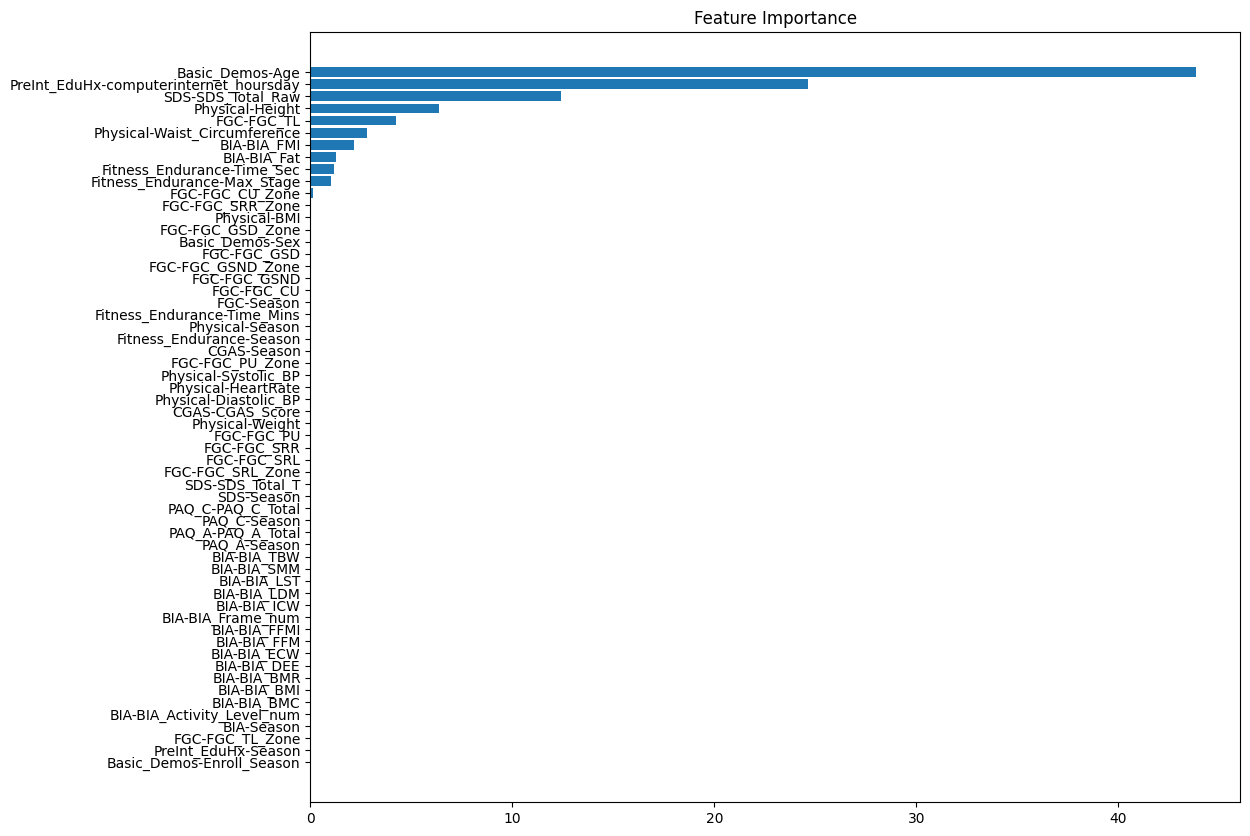

In [6]:
feature_importance = np.mean([model.get_feature_importance() for model in models], axis=0)
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title("Feature Importance")

Shout to Tubotubo for the amazing notebook!